In [1]:
import collections
import collections.abc

# 在导入 pyevolve 前先执行此处，让 pyevolve 里对 collections.Callable 的引用有效
collections.Callable = collections.abc.Callable

In [2]:
import sys
import pandas as pd
import math
import numpy as np
import MySQLdb
import logging
from pyevolve import G1DList
from pyevolve.GSimpleGA import GSimpleGA
from ga import Generation

### Preprocess

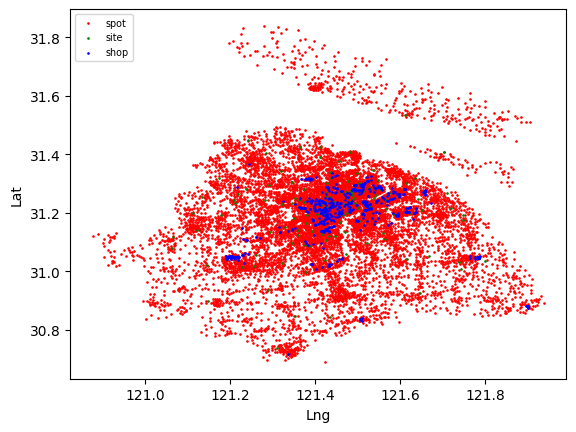

In [31]:
class DataPreprocessor:
    def __init__(self, filepath: str = None):
        if not filepath:
            return
        self.dataframe = pd.read_csv(filepath, header=0, index_col=0)

    def get_dataframe(self):
        return self.dataframe

    def draw_map(self, legend_names, *dataframes):
        import matplotlib.pyplot as plt
        colors = ['r', 'g', 'b']
        plt.figure(1)
        plt.subplot(111)
        plt.xlabel('Lng')
        plt.ylabel('Lat')
        marker_size = 0.8
        for i, df in enumerate(dataframes):
            if legend_names is None:
                plt.scatter(df.Lng, df.Lat, color=colors[i % 3], s=marker_size)
            else:
                plt.scatter(df.Lng, df.Lat, color=colors[i % 3], label=legend_names[i % 3], s=marker_size)

        if legend_names:
            plt.legend(loc='upper left', fontsize='x-small')
        plt.show()

if __name__ == '__main__':
    # Site (网点)
    site_processor = DataPreprocessor('./Dataset/new_1.csv')
    # Spot (配送点)
    spot_processor = DataPreprocessor('./Dataset/new_2.csv')
    # Shop (商户)
    shop_processor = DataPreprocessor('./Dataset/new_3.csv')
    # 电商订单
    ecommerce_orders_processor = DataPreprocessor('./Dataset/new_4.csv')
    # O2O订单
    o2o_orders_processor = DataPreprocessor('./Dataset/new_5.csv')
    # 快递员ID
    courier_processor = DataPreprocessor('./Dataset/new_6.csv')

    site = site_processor.get_dataframe()
    spot = spot_processor.get_dataframe()
    shop = shop_processor.get_dataframe()
    ecommerce_orders = ecommerce_orders_processor.get_dataframe()
    o2o_orders = o2o_orders_processor.get_dataframe()
    courier_ids = courier_processor.get_dataframe()

    preprocessor = DataPreprocessor()
    # 按照题目要求，legend 名称顺序：配送点 (spot)、网点 (site)、商户 (shop)
    preprocessor.draw_map(['spot', 'site', 'shop'], spot, site, shop)


### Genetic algo

In [14]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import sys
import math
import logging
import pandas as pd
import numpy as np
# 如果不需要数据库功能，可以注释掉下面两行
# import MySQLdb
# from MySQLdb.cursors import Cursor

from pyevolve import G1DList
from pyevolve.GSimpleGA import GSimpleGA
from ga import Generation  # 你的遗传算法实现

# Constants
EARTH_RADIUS = 6378.137           # 地球半径，单位km
VELOCITY = 0.25                   # 快递员行驶速度，单位km/分钟（15km/h）
MAX_CARRIAGE = 140                # 每个快递员最大携带包裹数
START_WORK = 8
END_WORK = 20
MAX_WORK_MINUTES = (END_WORK - START_WORK) * 60

class OneKilo:
    def __init__(self):
        self.logger = logging.getLogger(__name__)
        # CSV 文件列表，CSV 文件中已包含列名，不再覆盖
        self.file_list = [f'./Dataset/new_{i}.csv' for i in range(1, 7)]
        # new_1: Site_id, Lng, Lat
        self.site = pd.read_csv(self.file_list[0], header=0, index_col=0)
        # new_2: Spot_id, Lng, Lat
        self.spot = pd.read_csv(self.file_list[1], header=0, index_col=0)
        # new_3: Shop_id, Lng, Lat
        self.shop = pd.read_csv(self.file_list[2], header=0, index_col=0)
        # new_4: Order_id, Spot_id, Site_id, Num   （电商订单）
        self.online_order = pd.read_csv(self.file_list[3], header=0, index_col=0)
        # new_5: Order_id, Spot_id, Shop_id, Pickup_time, Delivery_time, Num （O2O订单）
        self.o2o_order = pd.read_csv(self.file_list[4], header=0, index_col=0)
        # new_6: Courier_id
        self.courier = pd.read_csv(self.file_list[5], header=0, index_col=0)

        self.courier_used = 0

        # 初始化遗传算法参数时用的一个示例染色体，后续会根据停靠点数量动态生成
        self.gnome = G1DList.G1DList(10)
        self.GA_Generator = GSimpleGA

        # 保存最优方案下所有快递员的总耗时（原始值，未归一化）
        self.best_total_time = None

    def distance(self, lng1, lng2, lat1, lat2):
        delta_lng = (lng2 - lng1) / 2
        delta_lat = (lat2 - lat1) / 2
        angle = math.asin(math.sqrt(
            math.sin(math.pi * delta_lat / 180) ** 2 +
            math.cos(math.pi * lat1 / 180) * math.cos(math.pi * lat2 / 180) *
            math.sin(math.pi * delta_lng / 180) ** 2
        ))
        # 行驶时间 = 距离 / 速度
        return round(2 * EARTH_RADIUS * angle / VELOCITY)

    def service_time(self, package_count):
        return int(round(3 * math.sqrt(package_count) + 5))

    def convert_time_to_minutes(self, t: str) -> int:
        hours, minutes = map(int, t.split(':'))
        return (hours - START_WORK) * 60 + minutes

    def build_stops(self, site_id):
        stops = []
        # 第0个停靠点为起始网点
        stops.append({
            'type': 'site',
            'id': site_id,
            'num': 0,
            'order_id': '',
            'time_window': None
        })

        # 在线订单：筛选当前网点所有订单
        online_orders = self.online_order[self.online_order['Site_id'] == site_id]
        for order_id, row in online_orders.iterrows():
            stop = {
                'type': 'online',
                'id': row['Spot_id'],   # 配送点编号
                'num': row['Num'],
                'order_id': order_id,
                'time_window': None
            }
            stops.append(stop)

        # O2O订单：假设配送点属于当前网点服务范围
        # 这里简单采用配送点在当前网点内的订单（即其Spot_id在online订单中出现过）
        online_spots = set(online_orders['Spot_id'].unique())
        o2o_orders = self.o2o_order[self.o2o_order['Spot_id'].isin(online_spots)]
        for order_id, row in o2o_orders.iterrows():
            # 商户取件停靠点
            stop_pickup = {
                'type': 'o2o_pickup',
                'id': row['Shop_id'],   # 商户编号
                'num': row['Num'],
                'order_id': order_id,
                # 取件必须在此时间前到达；若提前则等待；晚到按超时处理
                'time_window': (self.convert_time_to_minutes(row['Pickup_time']), None)
            }
            stops.append(stop_pickup)
            # 配送点送达停靠点
            stop_delivery = {
                'type': 'o2o_delivery',
                'id': row['Spot_id'],   # 送达配送点
                'num': row['Num'],
                'order_id': order_id,
                # 送达不得晚于此时间；若提前无需等待
                'time_window': (None, self.convert_time_to_minutes(row['Delivery_time']))
            }
            stops.append(stop_delivery)
        return stops

    def combined_order_fitness(self, chromosome, stops):
        """
        遗传算法适应度函数：
         - 染色体结构：第一个基因为分配的快递员数量，
           接下来 N 个基因为停靠点（下标1~N）的配送顺序（排列），
           接下来 N 个基因为各停靠点的候选到达时间，
           接下来 N 个基因为各停靠点的候选离开时间。
         - N = len(stops) - 1（不含起始网点）。
         
         模拟每个快递员从起始网点出发依次服务分配的停靠点，
         在模拟过程中计算：
           a. 两停靠点之间实际行驶时间与候选到达时间之间的偏差（偏差×10计罚）
           b. 每个停靠点的候选离开时间与候选到达时间+理想服务时长之间的偏差（偏差×10计罚）
           c. 对于 O2O 订单的取件或配送时间窗，若超时（候选时间迟于要求），按超时分钟×5计罚；若提前到达，则快递员需要等待至规定时间（不罚，但影响后续时间）
           d. 若同一 O2O 订单的配送顺序中，送达停靠点在取件停靠点之前，给予较大惩罚
           e. 快递员任一时刻携带包裹数不得超过 MAX_CARRIAGE，否则重罚
         最终总耗时 = 累计行驶+服务时间 + 所有惩罚
         适应度 = 1 / (总耗时)
         
         同时记录 courier_tasks，保存每个快递员的详细配送计划：
         (快递员id, 地点类型, 地点编号, 到达时间, 离开时间, 取/送订单号, 包裹数量)
        """
        # 从染色体中解析基因
        # 假设 stops 数组长度为 M，且 M-1 = N（不含起始网点）
        M = len(stops)
        N = M - 1
        # 第一个基因：快递员数量
        courier_num = int(chromosome[0])
        # 接下来 N 个基因为配送顺序，基因值为1~N的排列
        order_seq = chromosome[1:1+N]
        # 接下来 N 个基因为候选到达时间
        cand_arr = chromosome[1+N:1+2*N]
        # 接下来 N 个基因为候选离开时间
        cand_dep = chromosome[1+2*N:1+3*N]

        # 将各停靠点按顺序排列（起始网点固定，后续按染色体顺序）
        # route_stops 存储的是停靠点索引，注意：起始网点固定为0
        route_stops = [0] + order_seq

        total_penalty = 0
        total_time = 0
        courier_tasks = {}  # {courier_index: [ (地点类型, 地点id, 到达时间, 离开时间, 订单号, 包裹数) ] }
        courier_indices = list(range(courier_num))
        current_courier = 0

        # 每个快递员初始状态：当前时间为0（对应8:00），位置为起始网点坐标，当前载荷（对于 O2O 订单）为0，
        # 对于在线订单，包裹在网点已装车，配送后载荷减少，故这里不累加在线订单载荷
        courier_state = [{
            'time': 0,
            'location': (float(self.site.loc[stops[0]['id'], 'Lng']), float(self.site.loc[stops[0]['id'], 'Lat'])),
            'load': 0,
            # 用于记录已取件的 O2O 订单，确保取件在送达之前
            'picked_orders': set()
        } for _ in range(courier_num)]

        # 记录各快递员的任务
        for c in range(courier_num):
            courier_tasks[c] = []
        
        # 遍历停靠点（染色体中候选时间按照排序顺序对应 order_seq 的顺序）
        # 此处使用一个索引 i 对应染色体中候选时间列表（i从0到N-1，对应 route_stops[1:]）
        for i, stop_index in enumerate(route_stops[1:], start=0):
            stop = stops[stop_index]
            # 取该停靠点候选到达和离开时间（候选时间为绝对分钟数，从8:00起）
            cand_arr_time = cand_arr[i]
            cand_dep_time = cand_dep[i]
            # 当前快递员状态
            state = courier_state[current_courier]
            prev_time = state['time']
            prev_loc = state['location']
            # 计算从上一地点到当前地点的理想行驶时间
            if stop['type'] in ['online', 'o2o_delivery']:
                # 当前停靠点坐标来自配送点数据
                dest_lng = float(self.spot.loc[stop['id'], 'Lng'])
                dest_lat = float(self.spot.loc[stop['id'], 'Lat'])
            elif stop['type'] == 'o2o_pickup':
                dest_lng = float(self.shop.loc[stop['id'], 'Lng'])
                dest_lat = float(self.shop.loc[stop['id'], 'Lat'])
            else:  # 'site'
                dest_lng = float(self.site.loc[stop['id'], 'Lng'])
                dest_lat = float(self.site.loc[stop['id'], 'Lat'])
            # 上一地点坐标
            prev_lng, prev_lat = prev_loc
            travel_time = self.distance(prev_lng, dest_lng, prev_lat, dest_lat)
            ideal_arrival = prev_time + travel_time
            # 计算行驶时间偏差惩罚
            travel_deviation = abs(cand_arr_time - ideal_arrival)
            total_penalty += 10 * travel_deviation

            # 根据停靠点类型计算理想服务（处理）时间及对应离开时间
            if stop['type'] == 'online':
                ideal_service = self.service_time(stop['num'])
                ideal_departure = cand_arr_time + ideal_service
            elif stop['type'] == 'o2o_pickup':
                pickup_deadline = stop['time_window'][0]  # 要求取件时间
                if cand_arr_time < pickup_deadline:
                    # 如果早到，则需要等待到 pickup_deadline再开始服务
                    waiting = pickup_deadline - cand_arr_time
                    ideal_arrival_adjusted = pickup_deadline
                else:
                    waiting = 0
                    delay = cand_arr_time - pickup_deadline
                    total_penalty += 5 * delay
                    ideal_arrival_adjusted = cand_arr_time
                ideal_service = self.service_time(stop['num'])
                ideal_departure = ideal_arrival_adjusted + ideal_service
            elif stop['type'] == 'o2o_delivery':
                delivery_deadline = stop['time_window'][1]
                if cand_arr_time > delivery_deadline:
                    delay = cand_arr_time - delivery_deadline
                    total_penalty += 5 * delay
                ideal_service = self.service_time(stop['num'])
                ideal_departure = cand_arr_time + ideal_service
            else:
                # 如果为起始网点，无服务时间
                ideal_departure = cand_arr_time

            # 服务时间偏差惩罚
            service_deviation = abs(cand_dep_time - ideal_departure)
            total_penalty += 10 * service_deviation

            # 更新快递员状态：时间取候选离开时间（认为该候选值为执行计划），位置更新为当前停靠点
            state['time'] = cand_dep_time
            if stop['type'] in ['online', 'o2o_delivery']:
                state['location'] = (float(self.spot.loc[stop['id'], 'Lng']),
                                     float(self.spot.loc[stop['id'], 'Lat']))
            elif stop['type'] == 'o2o_pickup':
                state['location'] = (float(self.shop.loc[stop['id'], 'Lng']),
                                     float(self.shop.loc[stop['id'], 'Lat']))
            else:
                state['location'] = (float(self.site.loc[stop['id'], 'Lng']),
                                     float(self.site.loc[stop['id'], 'Lat']))
            # 更新快递员载荷及对 O2O 订单的处理顺序
            if stop['type'] == 'o2o_pickup':
                state['load'] += stop['num']
                if state['load'] > MAX_CARRIAGE:
                    total_penalty += 10000  # 超载重罚
                state['picked_orders'].add(stop['order_id'])
            elif stop['type'] in ['online', 'o2o_delivery']:
                # 对在线订单和 O2O 送达，认为包裹被送达，载荷减少
                state['load'] -= stop['num']
                # 如果是 O2O 送达，但对应订单尚未取件，则惩罚（先送达）
                if stop['type'] == 'o2o_delivery' and stop['order_id'] not in state['picked_orders']:
                    total_penalty += 10000
            # 记录任务信息：注意，时间以分钟表示（从8:00起）
            courier_tasks.setdefault(current_courier, []).append(
                (stop['type'], stop['id'], cand_arr_time, cand_dep_time, stop['order_id'], stop['num'])
            )

            # 累计总时间（取各快递员最后一站的候选离开时间作为其完成时间）
            # 这里只作简单累加，后续再加上返回网点的时间
            # 如果当前快递员任务已满（例如货量达到上限），切换到下一个快递员
            # 这里简单采用：如果下一候选到达时间超过当前快递员已累计时间一定阈值，则换人
            if state['time'] > MAX_WORK_MINUTES * 0.9:
                current_courier += 1
                if current_courier >= courier_num:
                    current_courier = courier_num - 1  # 所有任务均由最后一名快递员完成
            total_time = max(total_time, state['time'])

        # 各快递员回到网点（起始点）的行驶时间
        for c in range(courier_num):
            state = courier_state[c]
            current_loc = state['location']
            site_id = stops[0]['id']
            site_lng = float(self.site.loc[site_id, 'Lng'])
            site_lat = float(self.site.loc[site_id, 'Lat'])
            travel_back = self.distance(current_loc[0], site_lng, current_loc[1], site_lat)
            ideal_back = state['time'] + travel_back
            # 假设快递员返回网点的候选时间与理想时间相符，否则计罚
            # 这里未在染色体中编码返回时间，直接加上理想行驶时间
            total_time = max(total_time, ideal_back)
            total_penalty += 10 * 0  # 如果有返回时间偏差，可在此增加惩罚

        raw_total = total_time + total_penalty
        self.best_total_time = raw_total

        # 归一化后计算适应度
        fitness = 1.0 / (raw_total + 1)  # 加1避免除0
        return fitness, route_stops, courier_tasks

    def combined_dispatch(self):
        # 对每个网点分别求解
        site_ids = self.online_order['Site_id'].unique()
        count = 0
        with open('./results/solution_combined_genetic.csv', 'w', encoding='gbk') as fw:
            for site_id in site_ids:
                stops = self.build_stops(site_id)
                # 设定在线订单包裹总数，计算最大快递员数（简单近似：总包裹数/MAX_CARRIAGE+1）
                online_orders = self.online_order[self.online_order['Site_id'] == site_id]
                total_online = online_orders['Num'].sum()
                max_courier_num = int(total_online / MAX_CARRIAGE) + 1

                # 染色体长度 = 1 + 3 * N，其中 N = len(stops)-1（不含起始网点）
                N = len(stops) - 1
                chromo_length = 1 + 3 * N

                # 初始化遗传算法（此处假设 Generation 类可接收自定义染色体长度及适应度函数）
                ga = Generation(
                    lambda chromo: self.combined_order_fitness(chromo, stops),
                    groupnum=30,
                    generation=30,
                    var_num=chromo_length,
                    crossrate=0.8,
                    variationrate=0.8,
                    var_minrange=[max(1, max_courier_num // 3)] * chromo_length,
                    var_maxrange=[max(1, max_courier_num)] * chromo_length,
                    decodemap=None  # 这里自行在适应度函数中解析染色体
                )
                fitness, route, courier_tasks = ga.geneEvolve()
                self.logger.info(f"Site {site_id}: Best Total Time = {self.best_total_time} minutes")
                
                # 输出每个快递员的配送计划
                for courier_id, tasks in sorted(courier_tasks.items(), key=lambda x: x[0]):
                    current_courier_id = f'D{self.courier_used + courier_id + 1:04d}'
                    for task in tasks:
                        # task: (stop_type, addr, arr_time, dep_time, order_id, num)
                        # 输出格式：快递员id, 地点(网点/配送点/商户), 到达时间, 离开时间, 包裹量, 订单号
                        addr = task[1]
                        arr_time = str(int(task[2]))
                        dep_time = str(int(task[3]))
                        amount = str(task[5])
                        order_id = str(task[4])
                        line = ','.join([current_courier_id, addr, arr_time, dep_time, amount, order_id])
                        fw.write(line + '\n')
                self.courier_used += len(courier_tasks)
                count += 1
                self.logger.info(f'------------------>Current site processed: {count}')
        if self.best_total_time is not None:
            print(f"Total time consumed by all couriers: {self.best_total_time} minutes")



    
    def concise_info(self):
        print(len(self.online_order))
        print(len(self.o2o_order))

        site_to_spot_dist = {}
        site_to_spot_packages = {}
        place_count = 0
        for site_id in self.site.index:
            site_lng = float(self.site.loc[site_id, 'Lng'])
            site_lat = float(self.site.loc[site_id, 'Lat'])
            spot_ids = self.online_order.loc[self.online_order['Site_id'] == site_id, 'Spot_id'].values
            for spot_id in spot_ids:
                dest_lng = self.spot.loc[spot_id, 'Lng']
                dest_lat = self.spot.loc[spot_id, 'Lat']
                packages = self.online_order.loc[self.online_order['Spot_id'] == spot_id, 'Num'].values[0]
                dist = self.distance(dest_lng, site_lng, dest_lat, site_lat)
                site_to_spot_dist.setdefault(site_id, {})[spot_id] = dist
                site_to_spot_packages.setdefault(site_id, {})[spot_id] = packages
                place_count += 1

        print(place_count)
        max_site_count = max(len(v) for v in site_to_spot_packages.values())
        max_packages = max(max(v.values()) for v in site_to_spot_packages.values())
        print(max_site_count, max_packages)

        shop_to_spot_dist = {}
        shop_to_spot_info = {}
        place_count = 0
        for shop_id in self.shop.index:
            shop_lng = float(self.shop.loc[shop_id, 'Lng'])
            shop_lat = float(self.shop.loc[shop_id, 'Lat'])
            spot_ids = self.o2o_order.loc[self.o2o_order['Shop_id'] == shop_id, 'Spot_id'].values
            for spot_id in spot_ids:
                dest_lng = self.spot.loc[spot_id, 'Lng']
                dest_lat = self.spot.loc[spot_id, 'Lat']
                total_packages = self.o2o_order.loc[self.o2o_order['Spot_id'] == spot_id, 'Num'].values
                total_pickup = self.o2o_order.loc[self.o2o_order['Spot_id'] == spot_id, 'Pickup_time'].values
                total_deliver = self.o2o_order.loc[self.o2o_order['Spot_id'] == spot_id, 'Delivery_time'].values
                for i in range(len(total_pickup)):
                    pt = self.convert_time_to_minutes(total_pickup[i])
                    dt = self.convert_time_to_minutes(total_deliver[i])
                    pkg = total_packages[i]
                    shop_to_spot_info.setdefault(shop_id, {})[spot_id] = (pt, dt, pkg)
                shop_to_spot_dist.setdefault(shop_id, {})[spot_id] = self.distance(dest_lng, shop_lng, dest_lat, shop_lat)
                place_count += 1

        max_shop_count = max(len(v) for v in shop_to_spot_info.values())
        print(max_shop_count)
        print(place_count)


if __name__ == '__main__':
    app = OneKilo()
    app.combined_dispatch()
    # app.concise_info()

Total time consumed by all couriers: 217678 minutes


In [15]:
import pandas as pd

# 读取 CSV 文件（注意编码和分隔符是否需要调整，本例假设用逗号分隔，编码为 gbk）
df = pd.read_csv('./results/solution_combined_genetic.csv', header=None, encoding='gbk')

# 假设第一列为快递员编号
unique_couriers = df[0].unique()
print("不同快递员的数量:", len(unique_couriers))

不同快递员的数量: 935


In [16]:
import pandas as pd

# 读取 CSV 文件（注意编码和分隔符是否需要调整，本例假设用逗号分隔，编码为 gbk）
df = pd.read_csv('./results/solution_combined_genetic.csv', header=None, encoding='gbk')

# 假设第一列为快递员编号，例如 "D0001"
courier_ids = df[0].unique()
print("不同快递员的数量:", len(courier_ids))

# 提取编号的数值部分，并排序
nums = sorted([int(cid[1:]) for cid in courier_ids if cid.startswith('D')])
print("当前快递员编号数值:", nums)

# 找出范围内缺失的编号
missing = [f"D{n:04d}" for n in range(nums[0], nums[-1] + 1) if n not in nums]
print("缺失的快递员编号:", missing)

不同快递员的数量: 935
当前快递员编号数值: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 102, 103, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 261, 262, 263, 264, 265, 266, 267, 268, 26